<a href="https://colab.research.google.com/github/201524495/2021_FSRnT/blob/main/imageLoad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [181]:
print(tf.__version__)

2.4.1


In [182]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url,
                                   fname = 'flower_photos',
                                   untar = True)
data_dir = pathlib.Path(data_dir)

In [183]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


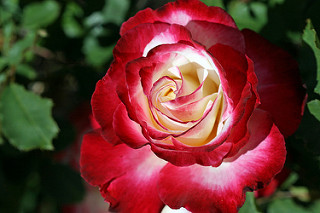

In [184]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [185]:
# keras.preprocessing을 사용하여 로드하기
#Data Set 만들기 & 매개변수 정의
batch_size = 32
img_height= 180
img_width = 180

In [186]:
# 분할 검증 사용
# 훈련 80 : 검증 20
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [187]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [188]:
# "class_names"에서 클래스 이름을 찾을 수 있다.
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


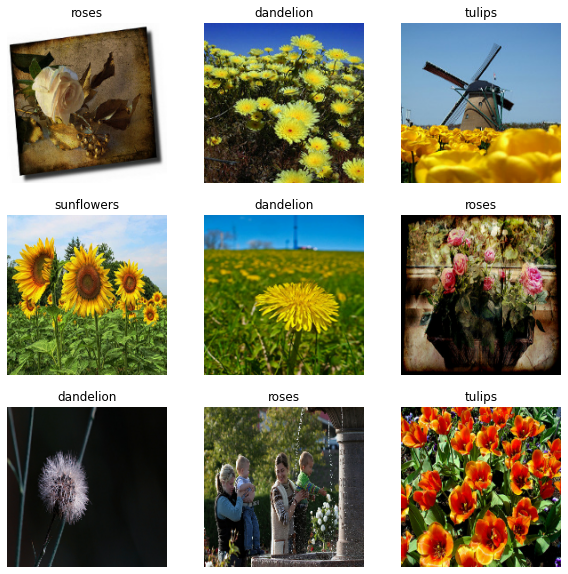

In [189]:
# data visualization
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [190]:
# image_batch : 180 X 180 X 3의 32개 이미지 배치 ( 마지막 치수는 RGB를 나타냄)
# label_batch : 32개의 이미지에 해당하는 레이블
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [191]:
# data standardization
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [192]:
# Rescaling 레이어를 사용하여 값이 [0, 1]에 있도록 표준화
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# 
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


cache()는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련한는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

In [193]:
# 성능을 위한 데이터세트 구성
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [194]:
# 모델 훈련
num_classes = 5

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

In [195]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [196]:
model.fit(
    train_ds,
    batch_size = batch_size,
    validation_data = val_ds,
    epochs = 3
)
# 검증 정확성이 훈련 정확성에 비해 낮으므로 모델이 Overfitting 되었음을 알 수 있습니다.

Epoch 1/3
92/92 [==============================] - 112s 1s/step - loss: 1.4793 - accuracy: 0.3752 - val_loss: 1.1078 - val_accuracy: 0.5668
Epoch 2/3
92/92 [==============================] - 103s 1s/step - loss: 1.0474 - accuracy: 0.5873 - val_loss: 0.9884 - val_accuracy: 0.6144
Epoch 3/3
92/92 [==============================] - 103s 1s/step - loss: 0.8864 - accuracy: 0.6500 - val_loss: 0.9634 - val_accuracy: 0.6281


In [197]:
# 미세 제어을 위해 tf.data 사용하기
# 
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle = False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration = False)

In [198]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/2333321040_3960b9d67e_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/2477986396_19da36d557_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/2229804138_db9cba3443_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/5083072098_81587295d5.jpg'
b'/root/.keras/datasets/flower_photos/daisy/4563059851_45a9d21a75.jpg'


In [199]:
# 파일의 트리 구조를 사용하여 "class_names" 목록을 컴파일할 수 있다.
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [200]:
# 데이터세트를 훈련 및 검증으로 분할
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [201]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [202]:
# 
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class - directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [203]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels = 3)
  # resize tje o,age tp tje desored soze
  return tf.image.resize(img, [img_height, img_width])

In [204]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [205]:
# Set 'num_parallel_calls' so multiple images are loaded / processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [206]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


In [214]:
# 성능을 위한 데이터세트 구하기
#잘 섞는다 
#배치 처리한다.
#가능한 빨리 배치를 사용할 수 있어야 한다.
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

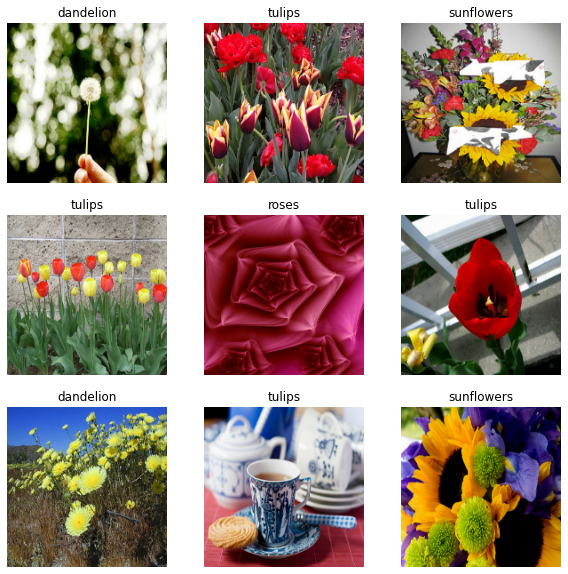

In [215]:
#data visualization
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize = (10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [217]:
#모델 훈련
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 112s 1s/step - loss: 0.7566 - accuracy: 0.7115 - val_loss: 0.7092 - val_accuracy: 0.7302
Epoch 2/3
92/92 [==============================] - 104s 1s/step - loss: 0.5345 - accuracy: 0.7994 - val_loss: 0.8166 - val_accuracy: 0.7016
Epoch 3/3
92/92 [==============================] - 104s 1s/step - loss: 0.3419 - accuracy: 0.8825 - val_loss: 0.8551 - val_accuracy: 0.7057


In [218]:
#Tensorflow dataset 사용하기
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [219]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


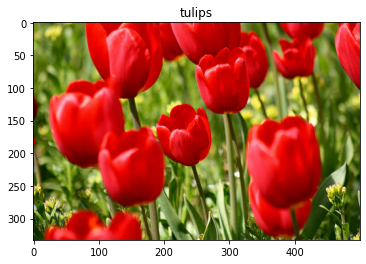

In [221]:
# 이미지 검색
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))

_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [222]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)